In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


# Loading Datasets

In [2]:
data_movie = pd.read_csv("movie.csv") #Datset eccontaining movie names
data_rating = pd.read_csv("rating.csv") #Dataset with rating of the movies given by each user

# Data Modelling

In [3]:
data_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data_movie.shape

(27278, 3)

In [5]:
#n collaborative filtering we dont ned the content of the item.
data_movie.drop(['genres'],axis=1,inplace=True)

In [6]:
data_rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [7]:
#droping timesttamp column
data_rating = data_rating.loc[:,["userId","movieId","rating"]]
data_rating.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


We will merge the movie and rating dataset


In [8]:
df = pd.merge(data_movie,data_rating)
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),3,4.0
1,1,Toy Story (1995),6,5.0
2,1,Toy Story (1995),8,4.0
3,1,Toy Story (1995),10,4.0
4,1,Toy Story (1995),11,4.5


In [9]:
df.describe()

,movieId,userId,rating
count,1.942403e+06,1.942403e+06,1.942402e+06
mean,8.672203e+03,6.567548e+03,3.519550e+00
std,1.913301e+04,3.795027e+03,1.049812e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,9.040000e+02,3.283000e+03,3.000000e+00
50%,2.153000e+03,6.545000e+03,3.500000e+00
75%,4.643000e+03,9.841000e+03,4.000000e+00
max,1.307680e+05,1.315500e+04,5.000000e+00


# Analysing the data

The movies which have been rated by most number of users:

In [10]:
df.groupby("title").count()["rating"].sort_values(ascending=False).head(20)

title
Pulp Fiction (1994)                                      6479
Forrest Gump (1994)                                      6412
Silence of the Lambs, The (1991)                         6024
Shawshank Redemption, The (1994)                         5997
Jurassic Park (1993)                                     5770
Star Wars: Episode IV - A New Hope (1977)                5290
Braveheart (1995)                                        5175
Terminator 2: Judgment Day (1991)                        5101
Matrix, The (1999)                                       4963
Schindler's List (1993)                                  4812
Fugitive, The (1993)                                     4804
Toy Story (1995)                                         4730
Apollo 13 (1995)                                         4630
Independence Day (a.k.a. ID4) (1996)                     4581
Star Wars: Episode VI - Return of the Jedi (1983)        4568
Usual Suspects, The (1995)                               4531
St

In [11]:
df.groupby("title").count()["rating"].sort_values(ascending=False).tail(20)

title
I Can't Think Straight (2007)                                                      1
I Am Curious (Blue) (Jag är nyfiken - en film i blått) (1968)                      1
I Am (2010)                                                                        1
I Always Wanted to Be a Gangster (J'ai toujours rêvé d'être un gangster) (2007)    1
How the West Was Fun (1994)                                                        1
How to Die in Oregon (2011)                                                        1
How to Draw a Bunny (2002)                                                         1
How to Make Love to a Woman (2010)                                                 1
How to Make Money Selling Drugs (2013)                                             1
How to Survive a Plague (2012)                                                     1
Hukkle (2002)                                                                      1
Human Experience, The (2008)                               

There are some movies with very few user ratings.
Similarly there are users who gave rating to very few movies.
This may cause inaccuracy in the code.
So deleting the movies with less than 200 reviews and deleting users who gave less 100 reviews would increase the accuracy of the model.

In [12]:
counts1 = df['userId'].value_counts()
df = df[df['userId'].isin(counts1[counts1 >= 100].index)]

counts2 = df['movieId'].value_counts()
df =df[df['movieId'].isin(counts2[counts2 >= 200].index)]

Checking the most common rating given by users:

<function matplotlib.pyplot.show>

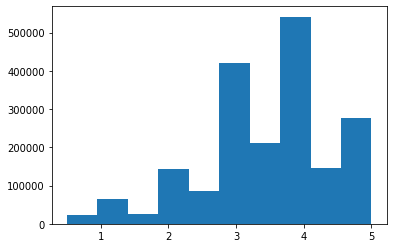

In [13]:
plt.hist(data_rating['rating'])
plt.show

Observation: 3-4 is the most common rating of the movies

Checking mean rating of the movies

(array([  5.,  14.,  29.,  74., 179., 285., 388., 494., 314.,  61.]),
 array([1.55325444, 1.84187716, 2.13049989, 2.41912262, 2.70774535,
        2.99636807, 3.2849908 , 3.57361353, 3.86223625, 4.15085898,
        4.43948171]),
 <a list of 10 Patch objects>)

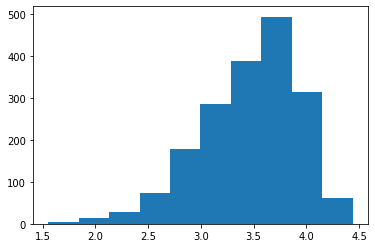

In [14]:
plt.hist(df.groupby("title").mean()['rating'].sort_values(ascending=False))

As we can see that the ratings and mean ratings are fairly distrubuted, which makes it great for recommendations.

# Recommending Movies With KNN

Building a user vs item matrix

In [23]:
user_movie_table = df.pivot_table(index = ["movieId"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.head(10)

userId,1,3,7,11,14,18,21,22,23,24,25,29,31,35,46,51,53,54,56,58,61,69,70,73,77,82,88,89,90,91,96,101,103,104,109,112,116,124,129,130,...,13049,13052,13057,13058,13060,13064,13065,13067,13068,13069,13071,13075,13077,13079,13080,13084,13087,13090,13092,13094,13096,13102,13106,13108,13109,13110,13121,13122,13123,13128,13132,13135,13139,13140,13141,13142,13143,13148,13151,13155
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.0,0.0,4.5,4.5,0.0,0.0,3.0,4.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,3.5,4.0,3.5,0.0,0.0,0.0,3.5,0.0,3.0,5.0,4.0,3.0,...,4.5,0.0,3.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,5.0,4.5,0.0,5.0,0.0,5.0,5.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,5.0,5.0,0.0,3.5,4.0,3.0,3.0,0.0,0.0,3.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,...,4.0,3.0,2.5,0.0,0.0,2.0,0.0,0.0,3.0,3.5,0.0,0.0,4.0,0.0,0.0,0.0,3.0,2.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.5,3.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,3.5
3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,2.5,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,4.5,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,5.0,0.0,4.0,...,0.0,0.0,4.0,0.0,0.0,2.5,0.0,0.0,5.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,4.5,4.5,0.0,4.0,0.0,4.0
7,0.0,0.0,3.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,3.5,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,...,3.5,0.0,3.5,0.0,0.0,3.0,0.0,0.0,5.0,3.5,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,3.5
11,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,5.0,3.0,4.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,3.0,0.0,3.0,2.0


In [24]:
csr_data = csr_matrix(user_movie_table.values)
user_movie_table.reset_index(inplace=True)

In [25]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [26]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = data_movie[data_movie['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = user_movie_table[user_movie_table['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = user_movie_table.iloc[val[0]]['movieId']
            idx = data_movie[data_movie['movieId'] == movie_idx].index
            recommend_frame.append({'Title':data_movie.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [35]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Iron Man 2 (2010),0.400737
2,Sherlock Holmes (2009),0.393387
3,Batman Begins (2005),0.389063
4,V for Vendetta (2006),0.388568
5,"Bourne Ultimatum, The (2007)",0.380747
6,300 (2007),0.377235
7,Avatar (2009),0.371953
8,WALL·E (2008),0.333552
9,Star Trek (2009),0.327824
10,"Dark Knight, The (2008)",0.253700


# Saving Model and DataFrame

In [29]:
import joblib
joblib.dump(knn,"recommendation_model.pkl")

['recommendation_model.pkl']

In [36]:
df.to_csv('movie-user-rating.csv')